In [2]:
import gymnasium as gym
from gymnasium.wrappers.vector import NormalizeObservation, NormalizeReward, NumpyToTorch
import torch

In [2]:
num_envs = 16
env = gym.make_vec('LunarLander-v3', num_envs = num_envs)
# env = NormalizeObservation(env)
# env = NormalizeReward(env)
env = NumpyToTorch(env)

In [3]:
env.observation_space

Box([[ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.28

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-2.3340902 ,  1.3438296 , -6.405117  , -1.4809773 ,  3.0694475 ,
         3.0814896 ,  0.2859042 ,  0.25585464],
       [ 1.1256162 , -1.4707663 , -6.9412336 , -6.171778  , -2.7066417 ,
         8.750001  ,  0.8284734 ,  0.4578843 ],
       [-0.6483824 ,  2.498986  , -8.339862  ,  4.791202  ,  2.4649556 ,
         1.7305858 ,  0.34359708,  0.79153997],
       [ 0.02141332, -2.028586  ,  4.688346  ,  6.129346  ,  4.4644613 ,
        -1.6426663 ,  0.38048086,  0.03176923],
       [ 0.59265375, -0.4980486 , -9.881754  , -2.493198  , -3.964047  ,
        -0.05511697,  0.10844903,  0.78955555],
       [ 1.9348209 , -0.22902085,  3.8863702 ,  0.3085104 ,  3.1669233 ,
        -2.6410074 ,  0.295171  ,  0.84369445],
       [ 0.66897804,  0.9080192 , -4.5371504 , -1.9224147 ,  1.9172953 ,
        -4.360085  ,  0.6190675 ,  0.9360884 ],
       [ 0.4108087 ,  0.04672365, -4.6478877 ,  1.118764  ,  5.368342  ,
         8.86528   ,  0.10364645,  0.515703  ],
       [ 0.34065968,  1.8924618 

In [5]:
obs_sample.shape

(16, 8)

In [6]:
env.action_space

MultiDiscrete([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([2, 1, 3, 0, 1, 1, 0, 2, 2, 2, 0, 3, 0, 1, 1, 1])

In [8]:
states, info = env.reset()
states

tensor([[-4.4495e-03,  1.4183e+00, -4.5070e-01,  3.2836e-01,  5.1626e-03,
          1.0209e-01,  0.0000e+00,  0.0000e+00],
        [-3.6914e-03,  1.4094e+00, -3.7392e-01, -6.9593e-02,  4.2842e-03,
          8.4698e-02,  0.0000e+00,  0.0000e+00],
        [-6.0368e-03,  1.4116e+00, -6.1148e-01,  2.8704e-02,  7.0019e-03,
          1.3851e-01,  0.0000e+00,  0.0000e+00],
        [-4.5971e-03,  1.4190e+00, -4.6565e-01,  3.6048e-01,  5.3337e-03,
          1.0548e-01,  0.0000e+00,  0.0000e+00],
        [ 5.5164e-03,  1.4222e+00,  5.5873e-01,  5.0345e-01, -6.3852e-03,
         -1.2656e-01,  0.0000e+00,  0.0000e+00],
        [ 7.3373e-03,  1.4130e+00,  7.4317e-01,  9.0544e-02, -8.4953e-03,
         -1.6834e-01,  0.0000e+00,  0.0000e+00],
        [ 6.8985e-03,  1.4031e+00,  6.9873e-01, -3.4780e-01, -7.9868e-03,
         -1.5827e-01,  0.0000e+00,  0.0000e+00],
        [ 6.5479e-04,  1.4165e+00,  6.6310e-02,  2.5008e-01, -7.5196e-04,
         -1.5020e-02,  0.0000e+00,  0.0000e+00],
        [-3.1116

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

tensor([[-8.8172e-03,  1.4257e+00, -4.4229e-01,  3.2990e-01,  1.0612e-02,
          1.0900e-01,  0.0000e+00,  0.0000e+00],
        [-7.4533e-03,  1.4072e+00, -3.8222e-01, -9.5673e-02,  1.0236e-02,
          1.1905e-01,  0.0000e+00,  0.0000e+00],
        [-1.1988e-02,  1.4116e+00, -5.9987e-01,  3.4088e-03,  1.1683e-02,
          9.3630e-02,  0.0000e+00,  0.0000e+00],
        [-9.1947e-03,  1.4266e+00, -4.6502e-01,  3.3477e-01,  1.0546e-02,
          1.0425e-01,  0.0000e+00,  0.0000e+00],
        [ 1.0960e-02,  1.4330e+00,  5.4879e-01,  4.7726e-01, -1.0800e-02,
         -8.8296e-02,  0.0000e+00,  0.0000e+00],
        [ 1.4588e-02,  1.4144e+00,  7.3130e-01,  6.5398e-02, -1.4633e-02,
         -1.2277e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3797e-02,  1.3947e+00,  6.9778e-01, -3.7344e-01, -1.5808e-02,
         -1.5643e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3721e-03,  1.4229e+00,  7.2174e-02,  2.8279e-01, -1.1963e-03,
         -8.8862e-03,  0.0000e+00,  0.0000e+00],
        [-6.2214

In [11]:
rewards

tensor([-1.0039, -1.7785,  0.7176,  0.3122,  0.9312,  0.6478, -1.0400, -4.2933,
        -2.3115, -1.8444, -0.3510, -1.4308, -1.8562, -1.9172, -1.6277, -1.8125],
       dtype=torch.float64)

In [12]:
dones # done is when state successfully finished or passed

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])

In [13]:
terminated # terminated is when agent failed 

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])

In [4]:
from src.ppo import *

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
actor = Actor(8, 4, 213).to(device)
critic = Critic(8, 1, 101).to(device)

In [16]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([16, 4]))

In [17]:
test_sample = dist.sample()

In [18]:
dist.log_prob(test_sample)

tensor([-1.3473, -1.2808, -1.5407, -1.4234, -1.2547, -1.3081, -1.3246, -1.2832,
        -1.6694, -1.2955, -1.2861, -1.3594, -1.2246, -1.2507, -1.3770, -1.2363],
       grad_fn=<SqueezeBackward1>)

In [19]:
dist.log_prob(test_sample).exp()

tensor([0.2599, 0.2778, 0.2142, 0.2409, 0.2852, 0.2703, 0.2659, 0.2771, 0.1884,
        0.2738, 0.2764, 0.2568, 0.2939, 0.2863, 0.2523, 0.2905],
       grad_fn=<ExpBackward0>)

In [20]:
critic.forward(obs_sample)

tensor([[ 0.2731],
        [ 0.4580],
        [ 0.1830],
        [ 0.0940],
        [-0.1213],
        [ 0.0341],
        [-0.2477],
        [ 0.3777],
        [ 0.2111],
        [ 0.1887],
        [ 0.4962],
        [-0.0781],
        [ 0.2640],
        [ 0.0423],
        [ 0.0831],
        [-0.2507]], grad_fn=<AddmmBackward0>)

In [ ]:
actor = Actor(8, 4, 64)
critic = Critic(8, 1, 64)

total_episodes = 245
agent = Agent(actor, critic, 0.2, 0.999, 0.98, 0.5, 0.01, 0.0003, 0.003, device, 64)

In [22]:
train(env, agent, num_envs, total_episodes, 1024, 4, 'models/lunarlander_agent.pt', True)   

finished episode: 0
total reward: -32623.028576544573
number of steps: 1024
---------------
new best model... saving...
finished episode: 1
total reward: -21716.353404477122
number of steps: 1024
---------------
new best model... saving...
finished episode: 2
total reward: -17863.965783018168
number of steps: 1024
---------------
new best model... saving...
finished episode: 3
total reward: -13663.64424769898
number of steps: 1024
---------------
new best model... saving...
finished episode: 4
total reward: -10156.946363361532
number of steps: 1024
---------------
new best model... saving...
finished episode: 5
total reward: -6201.918986795082
number of steps: 1024
---------------
new best model... saving...
finished episode: 6
total reward: -2605.1320714964
number of steps: 1024
---------------
new best model... saving...
finished episode: 7
total reward: 37.0497630087012
number of steps: 1024
---------------
new best model... saving...
finished episode: 8
total reward: 901.1455268606

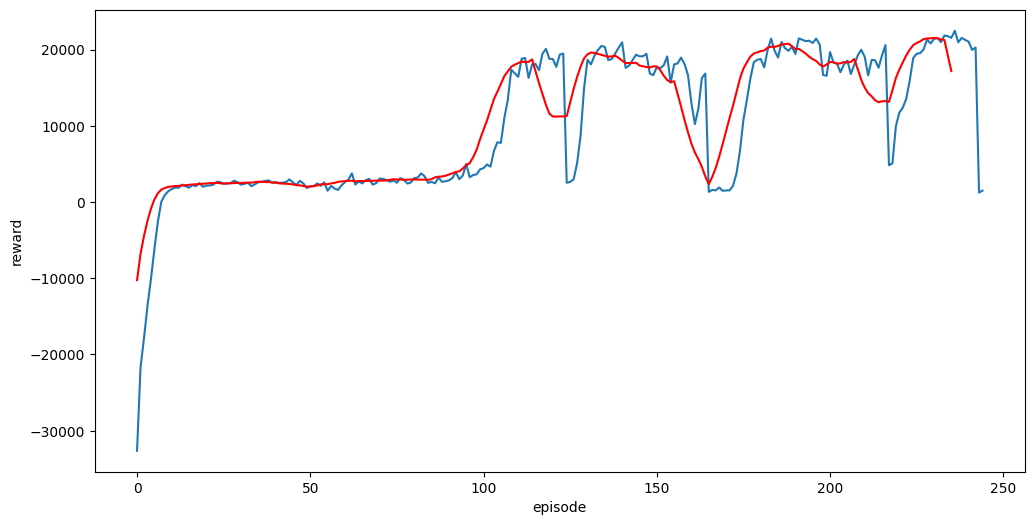

In [23]:
import matplotlib.pyplot as plt
window_size = 10
running_avg = []

for i in range(len(agent.all_rewards) - window_size + 1):
    window_sum = sum(agent.all_rewards[i:i + window_size])
    average = window_sum / window_size
    running_avg.append(average)

plt.figure(figsize = (12, 6))
plt.xlabel('episode')
plt.ylabel('reward')
plt.plot(agent.all_rewards)
plt.plot(running_avg, color = 'red')

Evaluation

In [5]:
def create_env(render_mode: str = 'human'):
    env = gym.make_vec('LunarLander-v3', render_mode = render_mode)
    env = NumpyToTorch(env)

    return env 

In [6]:
agent = Agent.load_agent('models/lunarlander_agent.pt', device)
agent.actor.eval()
agent.critic.eval()
env = create_env()

evaluate(env, 3, agent)

evaluation reward: 298.0296592222462
evaluation reward: 275.67463023830436
evaluation reward: 246.4423546833875
average reward: 273.38221471464607


In [7]:
env.close()

In [8]:
env = create_env('rgb_array')
evaluate(env, 100, agent)

evaluation reward: 252.23911132168394
evaluation reward: 264.20192997943474
evaluation reward: 303.5171142888765
evaluation reward: 293.71290850645624
evaluation reward: 266.06374075397764
evaluation reward: 273.5678712470066
evaluation reward: 295.05356203978647
evaluation reward: 303.1772671174797
evaluation reward: 261.7299496610119
evaluation reward: 240.64960089089848
evaluation reward: 295.83005388926597
evaluation reward: 246.6662424195515
evaluation reward: 275.1175786408882
evaluation reward: 241.03245005512457
evaluation reward: 263.6122182325685
evaluation reward: 242.82427170617598
evaluation reward: 261.62352964406887
evaluation reward: 286.06654686518425
evaluation reward: 255.95944077005123
evaluation reward: 254.03195223026435
evaluation reward: 292.86799837731655
evaluation reward: 296.55629885962355
evaluation reward: 256.37236509266756
evaluation reward: 307.63833144316317
evaluation reward: 293.7850254286325
evaluation reward: 320.8264323268339
evaluation reward: 29

In [9]:
env.close()